In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error

import xgboost as xgb

plt.style.use('ggplot')

In [93]:
from google.colab import drive
drive.mount('/content/gdrive')

drive_path = "Data Studies/datasets/Hourly Energy Consumption/"
base_path = "gdrive/MyDrive/" + drive_path

df_PJME_path = base_path + "PJME_hourly.csv"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Energy Consumption - Time Series Forecasting Study

by **Diego Kurashima**

This notebook is a study on the [Hourly Energy Consumption](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption/data) dataset for **Time Series Forecasting** problems.

## Importing the Data

For this study we'll focus on the **PJM East Region** (**PJME**) data

In [94]:
df_PJME = pd.read_csv(df_PJME_path)
df_PJME['Datetime'] = pd.to_datetime(df_PJME['Datetime'])

print("PJME Data Info:")
print(df_PJME.info())
print("\n")

PJME Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  145366 non-null  datetime64[ns]
 1   PJME_MW   145366 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.2 MB
None




## Exploratory Analysis (EDA)

First, we'll check for **duplicates** (rows).

In [95]:
print("Check of Duplicates:")
print(f"{df_PJME[df_PJME.duplicated()]}")

Check of Duplicates:
Empty DataFrame
Columns: [Datetime, PJME_MW]
Index: []


No duplicates were found. 😀

Now, let's check for **Missing Dates** based on the period in a hourly basis.

In [96]:
pd.date_range(start=df_PJME['Datetime'].iloc[0], end=df_PJME['Datetime'].iloc[-1], freq='h').difference(df_PJME['Datetime'])

DatetimeIndex(['2003-04-06 03:00:00', '2003-10-26 02:00:00',
               '2004-04-04 03:00:00', '2004-10-31 02:00:00',
               '2005-04-03 03:00:00', '2005-10-30 02:00:00',
               '2006-04-02 03:00:00', '2006-10-29 02:00:00',
               '2007-03-11 03:00:00', '2007-11-04 02:00:00',
               '2008-03-09 03:00:00', '2008-11-02 02:00:00',
               '2009-03-08 03:00:00', '2009-11-01 02:00:00',
               '2010-03-14 03:00:00', '2010-11-07 02:00:00',
               '2010-12-10 00:00:00', '2011-03-13 03:00:00',
               '2011-11-06 02:00:00', '2012-03-11 03:00:00',
               '2012-11-04 02:00:00', '2013-03-10 03:00:00',
               '2013-11-03 02:00:00', '2014-03-09 03:00:00',
               '2015-03-08 03:00:00', '2016-03-13 03:00:00',
               '2017-03-12 03:00:00'],
              dtype='datetime64[ns]', freq=None)

Some missing datetime were found. We'll have to handle them later.

### EDA - Overall Analysis

Let's create an **overall plot** of the energy consumption data for the whole period of the dataset.

<ipython-input-97-55160037acbe>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Model', loc='upper left', fontsize=10)


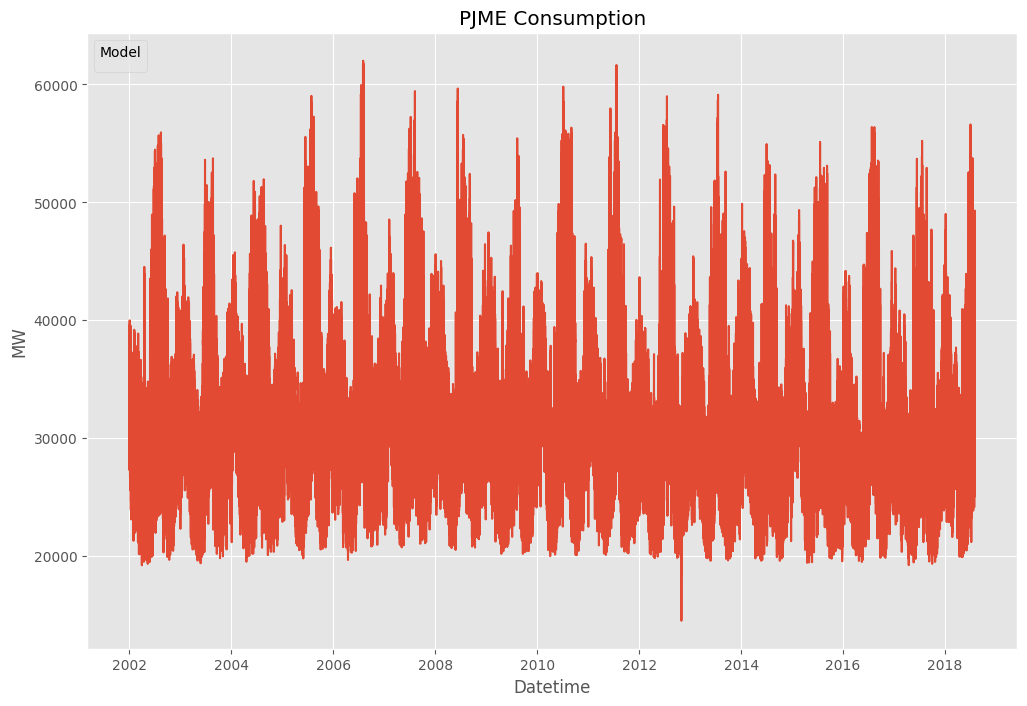

In [97]:
# Plots
plt.figure(figsize=(12, 8))

sns.lineplot(data=df_PJME, x='Datetime', y='PJME_MW')

plt.title('PJME Consumption')
plt.xlabel('Datetime')
plt.ylabel('MW')
plt.legend(title='Model', loc='upper left', fontsize=10)
plt.grid(True)

Let's get an **overall description** of the data.

In [98]:
df_PJME.describe()

,Datetime,PJME_MW
count,145366,145366.000000
mean,2010-04-18 03:25:25.999202048,32080.222831
min,2002-01-01 01:00:00,14544.000000
25%,2006-02-23 14:15:00,27573.000000
50%,2010-04-18 04:30:00,31421.000000
75%,2014-06-10 18:45:00,35650.000000
max,2018-08-03 00:00:00,62009.000000
std,NaN,6464.012166


We'll also plot a **Histogram** and a **Boxplot** to better understand the data.

Text(0.5, 1.0, 'Histogram for MW')

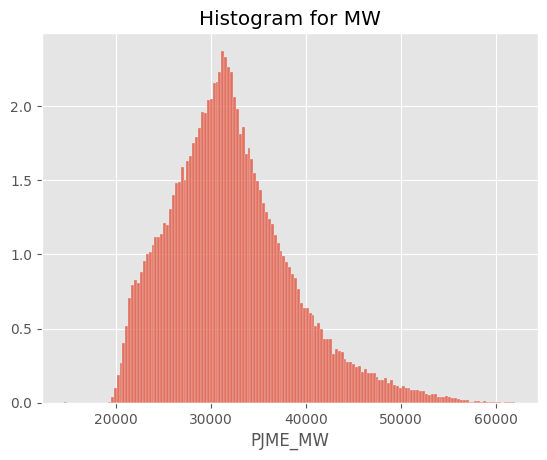

In [99]:
sns.histplot(data=df_PJME, x="PJME_MW", stat='percent')
plt.xlabel("PJME_MW")
plt.ylabel('')
plt.title('Histogram for MW')

Text(0.5, 1.0, 'Boxplot for MW')

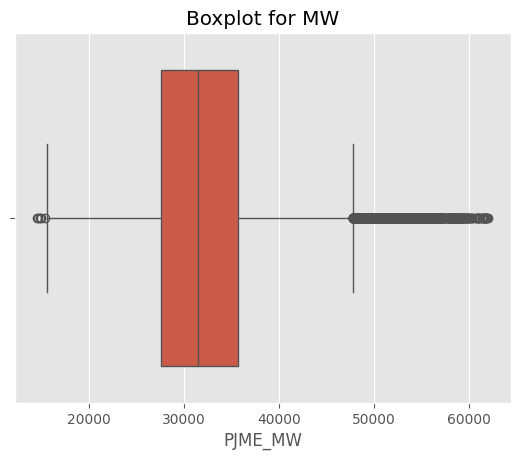

In [100]:
sns.boxplot(data=df_PJME, x="PJME_MW")
plt.xlabel("PJME_MW")
plt.ylabel('')
plt.title('Boxplot for MW')

From the data we may infer the data is slightly skewed (**Positive Skew**). Let's chek the skewness mathematically.

In [101]:
print(f"Skew: {df_PJME['PJME_MW'].skew()}")

Skew: 0.7390115207783634


Since the skew is greater than zero (>0) we confirm that the data for PJME_MW is slightly skewed to the left.

### EDA - Datetime


Since it is a time series data, let's analyse the data based on the datetime: **Year**, **Quarter**, **Month**, **Date**, **Hour**, ...

In addition, let's create feature whether it **Is_Weekend** or not.

We'll also create a feature to show **Season** based on USA Seasons (with full month):
1.  Spring
2.  Summer
3.  Fall
4.  Winter



In [102]:
# Standard Datetime Features
df_PJME['Year'] = df_PJME['Datetime'].dt.year
df_PJME['Quarter'] = df_PJME['Datetime'].dt.quarter
df_PJME['Month'] = df_PJME['Datetime'].dt.month
df_PJME['Day'] = df_PJME['Datetime'].dt.day
df_PJME['Hour'] = df_PJME['Datetime'].dt.hour

df_PJME['Day_of_Year'] = df_PJME['Datetime'].dt.dayofyear

df_PJME['Weekday'] = df_PJME['Datetime'].dt.weekday
df_PJME['Is_Weekend'] =  df_PJME['Datetime'].dt.day_name().isin(['Saturday', 'Sunday'])

# SEASON Feature
def create_feature_Season(row):
  if 3 <= row['Datetime'].month <= 5:
    return 1
  elif 6 <= row['Datetime'].month <= 8:
    return 2
  elif 9 <= row['Datetime'].month <= 11:
    return 3
  else:
    return 4

df_PJME['Season'] = df_PJME.apply(create_feature_Season, axis = 1)
df_PJME['Season_Name'] = df_PJME['Season'].map({1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'})

In [103]:
df_PJME.head(5)

,Datetime,PJME_MW,Year,Quarter,Month,Day,Hour,Day_of_Year,Weekday,Is_Weekend,Season,Season_Name
0,2002-12-31 01:00:00,26498.0,2002,4,12,31,1,365,1,False,4,Winter
1,2002-12-31 02:00:00,25147.0,2002,4,12,31,2,365,1,False,4,Winter
2,2002-12-31 03:00:00,24574.0,2002,4,12,31,3,365,1,False,4,Winter
3,2002-12-31 04:00:00,24393.0,2002,4,12,31,4,365,1,False,4,Winter
4,2002-12-31 05:00:00,24860.0,2002,4,12,31,5,365,1,False,4,Winter


Let's check the effect of Month, Hour and Weekday to the data.

Text(0.5, 1.0, 'PJME_MW by Weekday')

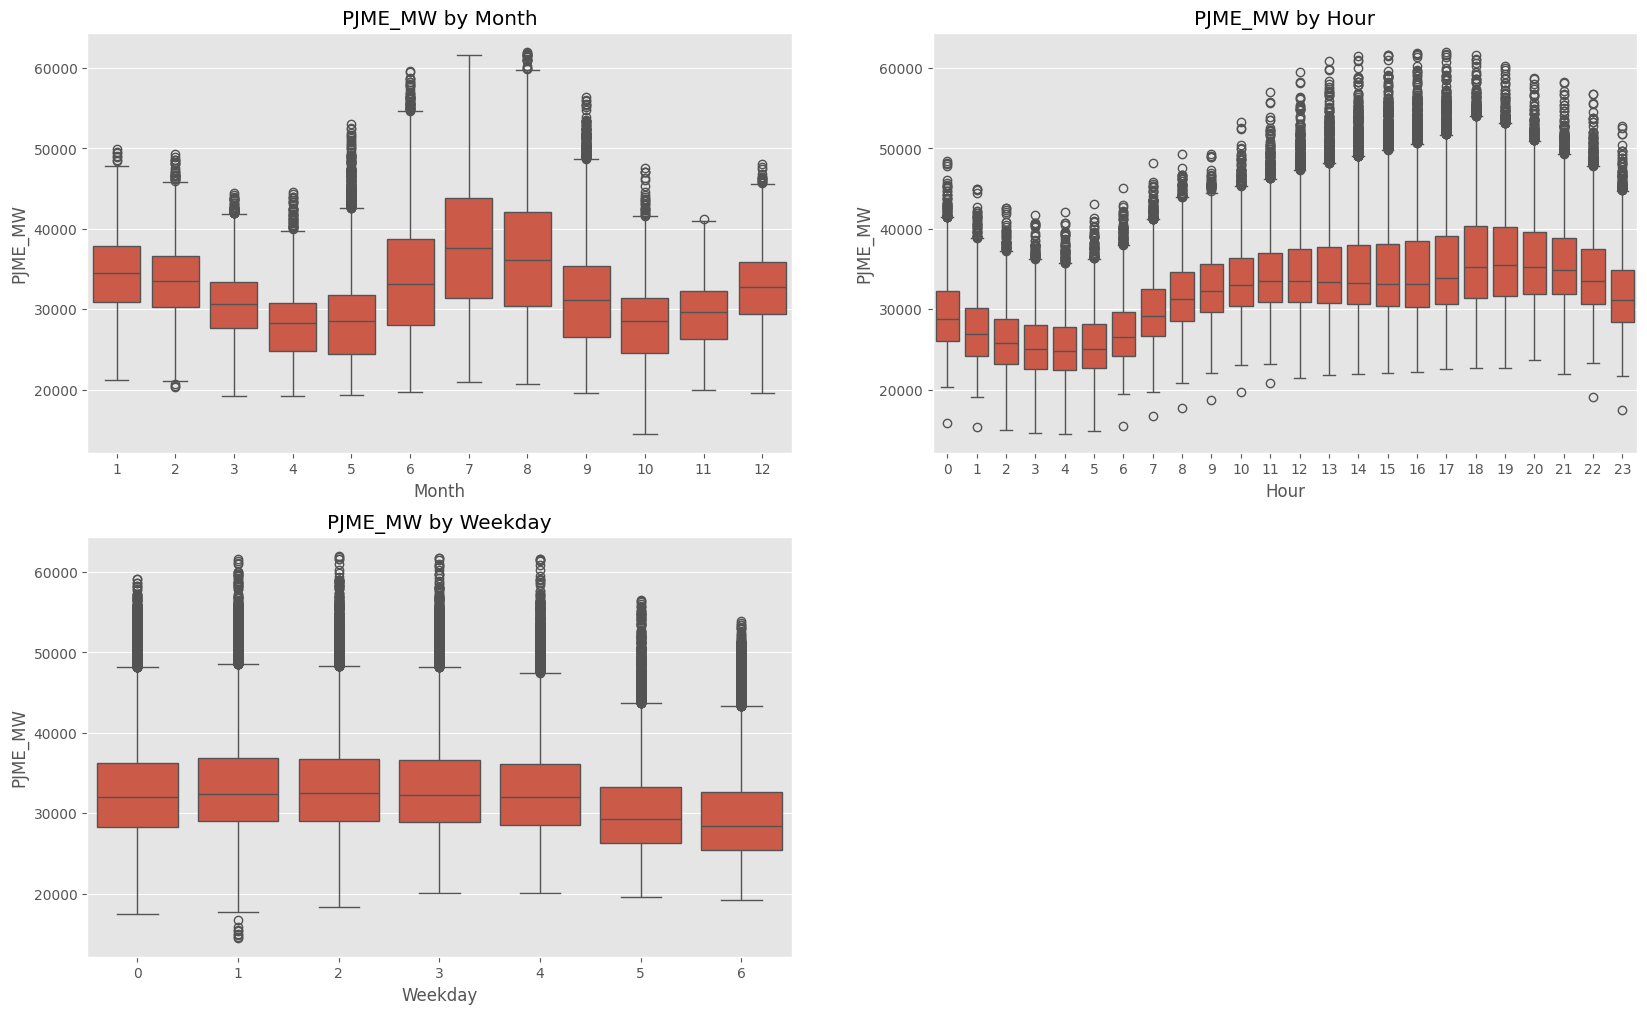

In [104]:
plt.figure(figsize=(20,12))

plt.subplot(2,2,1)
sns.boxplot(data=df_PJME, y='PJME_MW', x='Month')
plt.title('PJME_MW by Month')

plt.subplot(2,2,2)
sns.boxplot(data=df_PJME, y='PJME_MW', x='Hour')
plt.title('PJME_MW by Hour')

plt.subplot(2,2,3)
sns.boxplot(data=df_PJME, y='PJME_MW', x='Weekday')
plt.title('PJME_MW by Weekday')

Let's check if the Season affects the distribution of the data.

Text(0.5, 1.0, 'PJME_MW by Season')

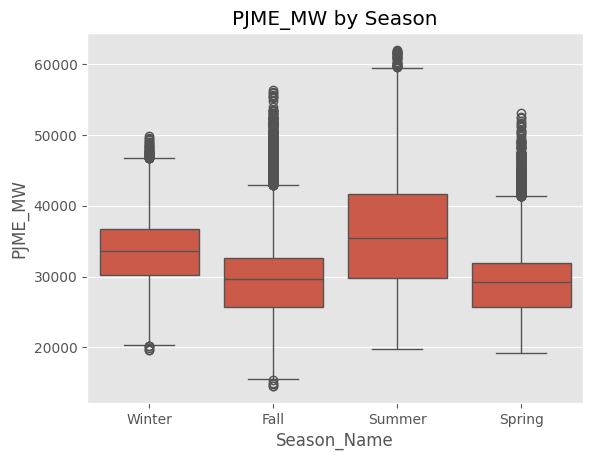

In [105]:
sns.boxplot(data=df_PJME, y="PJME_MW", x='Season_Name')
plt.title('PJME_MW by Season')

### EDA - Time Series Features

Now, we'll analyse the time series components. The main components of a Time Series are:
1.  Trends
2.  Seasonality
3.  Cycles
4.  Residuals

Let's plot the **Autocorrelation** to understand the data.

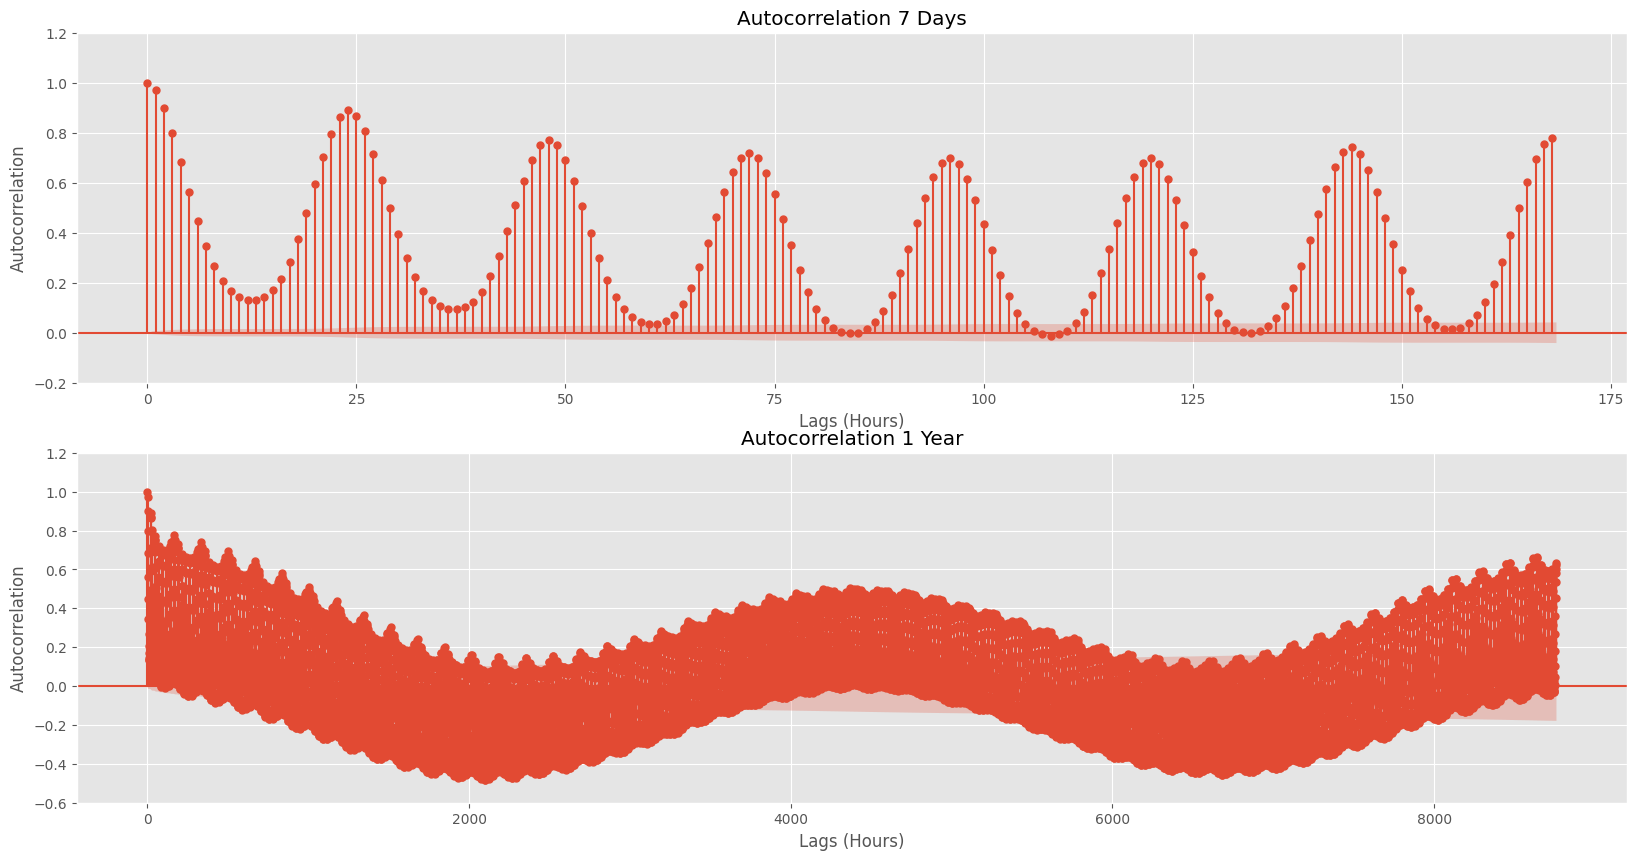

In [106]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

plot_acf(df_PJME['PJME_MW'], lags=24*7, ax=ax[0])

ax[0].set_title('Autocorrelation 7 Days')
ax[0].set_xlabel('Lags (Hours)')
ax[0].set_ylabel('Autocorrelation')
ax[0].set_ylim(-0.2, 1.2)
ax[0].grid(True)

plot_acf(df_PJME['PJME_MW'], lags=24*365, ax=ax[1])

ax[1].set_title('Autocorrelation 1 Year')
ax[1].set_xlabel('Lags (Hours)')
ax[1].set_ylabel('Autocorrelation')
ax[1].set_ylim(-0.6, 1.2)
ax[1].grid(True)

From the **7 days** autocorrelation, it is possible to identify a possible seasonality for a 24 hours (1 day) period.

Let's use "**seasonal_decompose**" from "statsmodels" library to get a first decomposition of the data into Trends, Seasonality and Residuals.

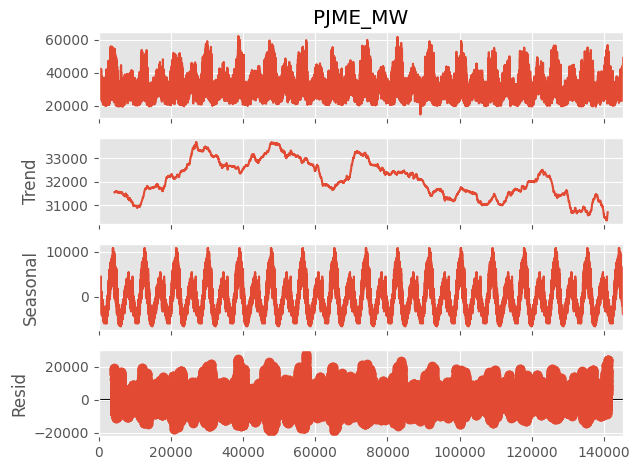

In [107]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_PJME['PJME_MW'], model='additive', period=365*24)
result.plot()
plt.show()

From the decomposition, we may infer that there is a relatively stable Trend and a Seasonality.

Let's start with **Trends**. We'll create a **Rolling Average** for a **1 Year** and **2 Years**.

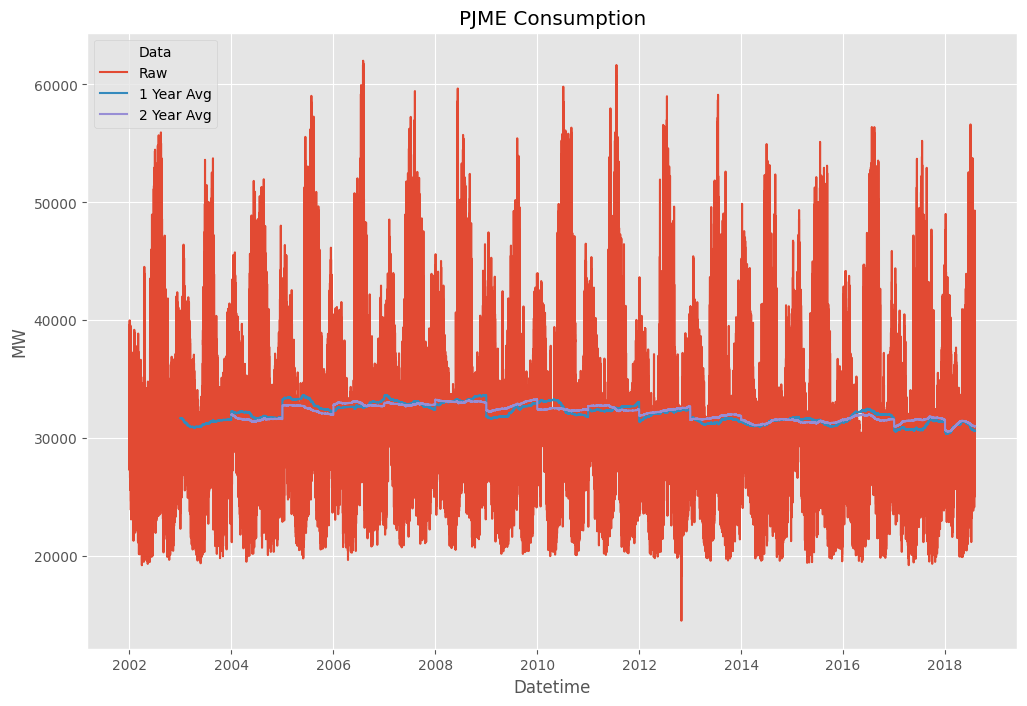

In [108]:
df_PJME_ts = df_PJME.copy()

df_PJME_ts[f'PJME_MW_Avg{1}y'] = df_PJME['PJME_MW'].rolling(24*365*1).mean()
df_PJME_ts[f'PJME_MW_Avg{2}y'] = df_PJME['PJME_MW'].rolling(24*365*2).mean()

# Plots
plt.figure(figsize=(12, 8))

sns.lineplot(data=df_PJME_ts, x='Datetime', y='PJME_MW', label ="Raw")
sns.lineplot(data=df_PJME_ts, x='Datetime', y=f'PJME_MW_Avg{1}y', label="1 Year Avg")
sns.lineplot(data=df_PJME_ts, x='Datetime', y=f'PJME_MW_Avg{2}y', label="2 Year Avg")

plt.title('PJME Consumption')
plt.xlabel('Datetime')
plt.ylabel('MW')
plt.legend(title='Data', loc='upper left', fontsize=10)
plt.grid(True)


There isn't any particular increase or decrease in the mean value of PJME_MW, so we may infer the data is stationary from this data.

To analyse **Seasonality**, let's plot the **periodogram** of the data.

<ipython-input-109-7d61ff7298de>:4: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / frequencies


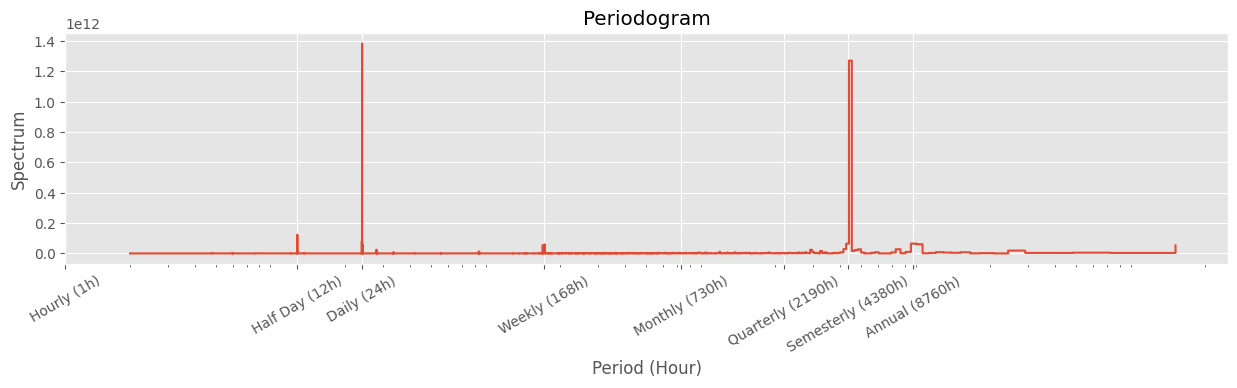

In [109]:
from scipy.signal import periodogram

frequencies, spectrum = periodogram(df_PJME['PJME_MW'].interpolate())
periods = 1 / frequencies

fig, ax = plt.subplots(figsize=(15, 3))
ax.step(periods, spectrum)
ax.set_title('Periodogram')
ax.set_xscale('log')
ax.xaxis.set_major_formatter('{x:,.0f}')

periods_featured = [1, 12, 24, 24*7, int(24*365/12), int(24*365/4), int(24*365/2), 24*365]
ax.set_xticks(periods_featured)
ax.set_xticklabels(["Hourly (1h)",
                    "Half Day (12h)",
                    f"Daily (24h)",
                    f"Weekly ({periods_featured[3]}h)",
                    f"Monthly ({periods_featured[4]}h)",
                    f"Quarterly ({periods_featured[5]}h)",
                    f"Semesterly ({periods_featured[6]}h)",
                    f"Annual ({periods_featured[7]}h)"],
                   rotation=30)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

plt.xlabel('Period (Hour)')
plt.ylabel('Spectrum')
plt.show()

We can identify a strong **Daily** and **Semesterly** seasonalities.

Let's create a **30 days** window average to analyse the effects of a **Semesterly** seasonality through each year.

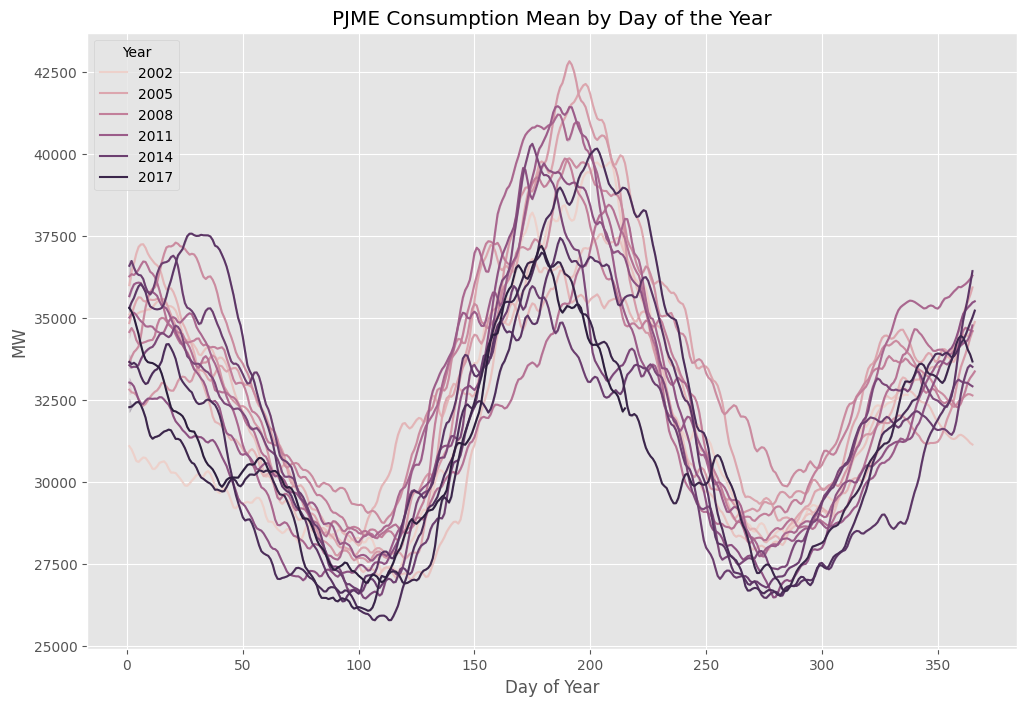

In [110]:
df_PJME_ts = df_PJME.copy()

df_PJME_ts[f'PJME_MW_Avg{30}d'] = df_PJME['PJME_MW'].rolling(24*30).mean()

# Plots
plt.figure(figsize=(12, 8))

#sns.lineplot(data=df_PJME_ts, x='Day_of_Year', y=f'PJME_MW', hue = 'Year')
sns.lineplot(data=df_PJME_ts, x='Day_of_Year', y=f'PJME_MW_Avg{30}d', hue = 'Year')

plt.title('PJME Consumption Mean by Day of the Year')
plt.xlabel('Day of Year')
plt.ylabel('MW')
plt.legend(title='Year', loc='upper left', fontsize=10)
plt.grid(True)

From the plot we can identify a strong pattern which repeats twice a year, similar to a sinusoidal wave, indicating that there is indeed a strong Semesterly seasonality.

Now let's check any pattern which repeats **Daily**. Let's group PJME_MW by Year and Hour to check these effects.

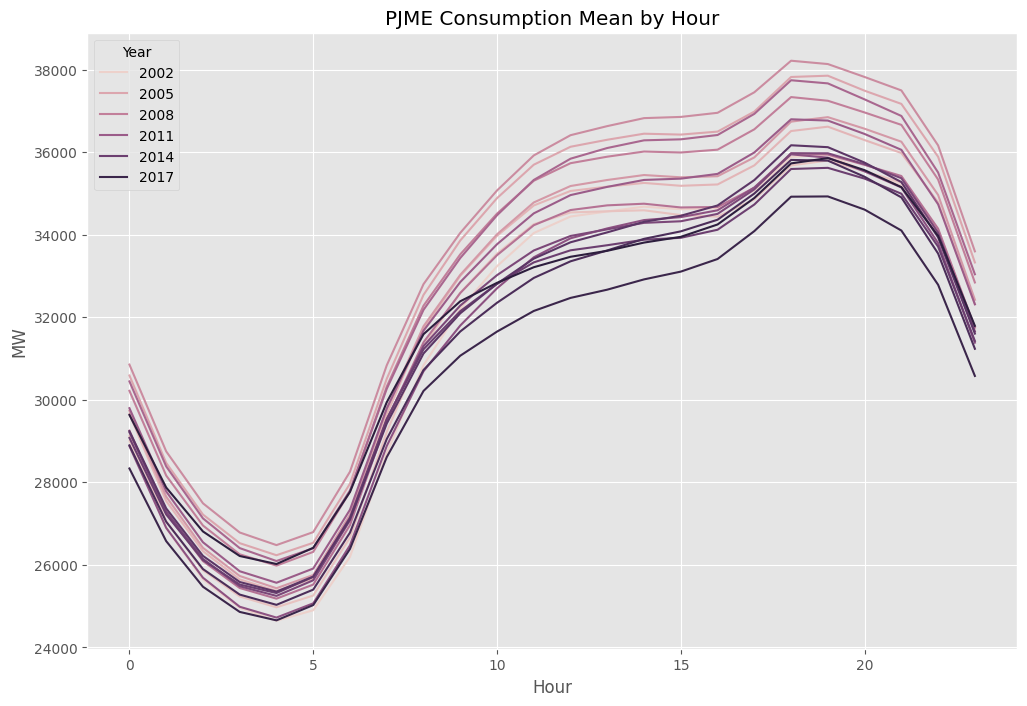

In [111]:
# Create Year and Month features
df_PJME_gbYearHour_meanMW = df_PJME[['Year', 'Hour', 'PJME_MW']].groupby(['Year', 'Hour'])['PJME_MW'].mean()

# Plots
plt.figure(figsize=(12, 8))

sns.lineplot(data=df_PJME_gbYearHour_meanMW.reset_index(), x='Hour', y='PJME_MW', hue = 'Year')

plt.title('PJME Consumption Mean by Hour')
plt.xlabel('Hour')
plt.ylabel('MW')
plt.legend(title='Year', loc='upper left', fontsize=10)
plt.grid(True)

From the plot, we can identify a pattern which repeats each year in a single day, indicating a Daily pattern as the periodogram inferred.

As for **Cycles**. Let's plot **Partial Autocorrelation** for **7 days lags**.

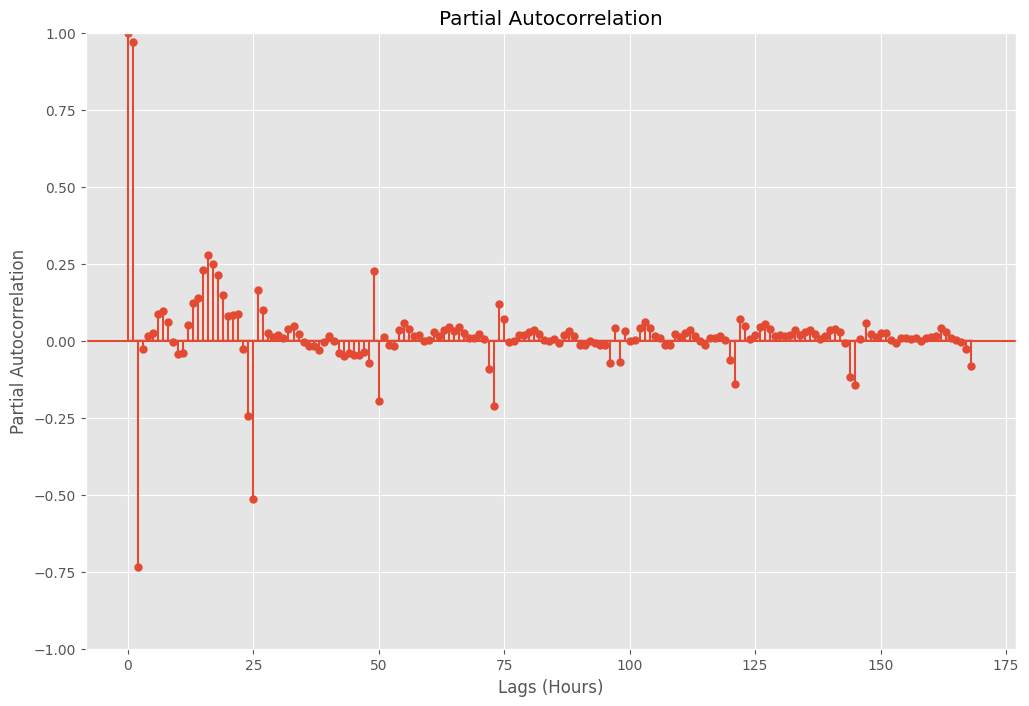

In [112]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plots
fig, ax = plt.subplots(1,1, figsize=(12, 8))

#plt.subplot(2,2,2)
plot_pacf(df_PJME['PJME_MW'], lags=24*7, ax=ax)
ax.set_title('Partial Autocorrelation')
ax.set_xlabel('Lags (Hours)')
ax.set_ylabel('Partial Autocorrelation')
#plt.legend(title='Model', loc='upper left', fontsize=10)
ax.grid(True)


From the Autocorrelation, we may infer a strong cyclicity which repeats every 24 hours, which we had already identified previously (Daily seasonality).

## Problem 1 - Forecast with Datetime Features

Let's define as our **Problem 1** the Forecast of PJME_MW based only on **datetime features** (such as Year, Month, Hour ...).

Since it is based only on datetime features, past values (lags and moving window statistics) will not matter in this first problem.

We'll set the data until 2017 as the Training and Test Data, and the data for 2018 as the Validation Data:
1.  **Training and Test**: data until 2017 Year
2.  **Validation**: 2018 Year

For

In [114]:
df_p1 = df_PJME.copy()

# Define Train and Target Columns
cols_train = ['Year', 'Quarter', 'Month', 'Day', 'Hour', 'Day_of_Year', 'Weekday', 'Is_Weekend', 'Season']
cols_target = ["PJME_MW"]

# Split Training and Validation Dataset
df_p1_training = df_p1[df_p1['Year'] <= 2017]
df_p1_validation = df_p1[df_p1['Year'] == 2018]

# XGB Regressor
reg = xgb.XGBRegressor(booster='gbtree',n_estimators=1000)

# Split Training into TRAIN and TEST for CROSS-VALIDATION
# Manual Cross-Validation
split_years = [2005, 2010, 2015, 2016, 2017]

preds = []
p1_cv_scores = []
for split in split_years:
  train = df_p1_training[df_p1_training['Year'] < split]
  test = df_p1_training[df_p1_training['Year'] == split]

  X_train = train[cols_train]
  y_train = train[cols_target]

  X_test = test[cols_train]
  y_test = test[cols_target]

  reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

  y_pred = reg.predict(X_test)
  preds.append(y_pred)
  score = root_mean_squared_error(y_test, y_pred)
  p1_cv_scores.append(score)

[0]	validation_0-rmse:4900.61118	validation_1-rmse:5824.86146
[100]	validation_0-rmse:872.31513	validation_1-rmse:4234.44849
[200]	validation_0-rmse:592.38748	validation_1-rmse:4330.71851
[300]	validation_0-rmse:454.40655	validation_1-rmse:4365.10048
[400]	validation_0-rmse:378.88021	validation_1-rmse:4379.89914
[500]	validation_0-rmse:324.11489	validation_1-rmse:4387.53533
[600]	validation_0-rmse:281.66240	validation_1-rmse:4392.81106
[700]	validation_0-rmse:250.79999	validation_1-rmse:4399.55892
[800]	validation_0-rmse:225.36831	validation_1-rmse:4402.73898
[900]	validation_0-rmse:205.89401	validation_1-rmse:4404.33052
[999]	validation_0-rmse:189.62818	validation_1-rmse:4405.58275
[0]	validation_0-rmse:5097.07402	validation_1-rmse:5704.27435
[100]	validation_0-rmse:1356.35427	validation_1-rmse:4354.42546
[200]	validation_0-rmse:1003.22939	validation_1-rmse:4436.48231
[300]	validation_0-rmse:826.75483	validation_1-rmse:4444.13683
[400]	validation_0-rmse:714.16225	validation_1-rmse:446

In [115]:
print(f'Score across folds {np.mean(p1_cv_scores):0.4f}')
print(f'Fold scores:{p1_cv_scores}')

Score across folds 4542.4083
Fold scores:[4405.5830078125, 4512.2744140625, 4212.34228515625, 4601.416015625, 4980.42578125]


Now, let's **Train** on the whole Training Data (until 2017 Year)

In [121]:
# TRAINING Proper
X_all = df_p1_training[cols_train]
y_all = df_p1_training[cols_target]

reg_p1 = xgb.XGBRegressor(booster='gbtree',n_estimators=1000)

reg_p1.fit(X_all, y_all, eval_set=[(X_all, y_all)], verbose=100)

[0]	validation_0-rmse:5221.36458
[100]	validation_0-rmse:1806.41735
[200]	validation_0-rmse:1427.48723
[300]	validation_0-rmse:1196.16146
[400]	validation_0-rmse:1062.06010
[500]	validation_0-rmse:959.02913
[600]	validation_0-rmse:880.96122
[700]	validation_0-rmse:819.55139
[800]	validation_0-rmse:775.48945
[900]	validation_0-rmse:735.09313
[999]	validation_0-rmse:697.64801


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Now we'll **Predict** the data for 2018, and compare with real values.

In [132]:
# PREDICTION
X_val = df_p1_validation[cols_train]
y_val = df_p1_validation[cols_target]

y_pred = reg_p1.predict(X_val)

# Dataframe with Predictions
df_p1_pred = df_p1_validation.copy()
df_p1_pred['PJME_MW_Pred'] = y_pred

# Overall RMSE

print("Problem 1 - RESULTS\n")

rmse_full = root_mean_squared_error(y_val, y_pred)
print(f"RMSE Overall: {rmse_full}")
print("\n")

# RMSE for each Month
for month in range(1,13):
  try:
    rmse = root_mean_squared_error(df_p1_pred[df_p1_pred['Month'] == month]['PJME_MW'], df_p1_pred[df_p1_pred['Month'] == month]['PJME_MW_Pred'])
    print(f"RMSE (month: {month}): {rmse}")
  except:
    pass
print("\n")

# RMSE for each Hour
for hour in range(0,24):
  try:
    rmse = root_mean_squared_error(df_p1_pred[df_p1_pred['Hour'] == hour]['PJME_MW'], df_p1_pred[df_p1_pred['Hour'] == hour]['PJME_MW_Pred'])
    print(f"RMSE (hour: {hour}): {rmse}")
  except:
    pass
print("\n")

Problem 1 - RESULTS

RMSE Overall: 4548.17236328125


RMSE (month: 1): 5951.742454039575
RMSE (month: 2): 3052.411438839782
RMSE (month: 3): 2667.0244099078886
RMSE (month: 4): 2650.5949667503546
RMSE (month: 5): 5114.572929365319
RMSE (month: 6): 5454.347077925473
RMSE (month: 7): 5430.244688525697
RMSE (month: 8): 3071.499359433566


RMSE (hour: 0): 4036.5184603109233
RMSE (hour: 1): 3921.577823627428
RMSE (hour: 2): 3851.939098732201
RMSE (hour: 3): 3803.5410111065203
RMSE (hour: 4): 3796.3304268904963
RMSE (hour: 5): 3822.8866393653393
RMSE (hour: 6): 3884.5945025495653
RMSE (hour: 7): 3875.6844956402083
RMSE (hour: 8): 3943.4650404222652
RMSE (hour: 9): 3923.166932716232
RMSE (hour: 10): 4000.0685030798927
RMSE (hour: 11): 4266.315480066827
RMSE (hour: 12): 4557.763427064033
RMSE (hour: 13): 4810.540640879998
RMSE (hour: 14): 5050.1089080299325
RMSE (hour: 15): 5282.045634046217
RMSE (hour: 16): 5408.070321393952
RMSE (hour: 17): 5512.951481410597
RMSE (hour: 18): 5476.09207825310

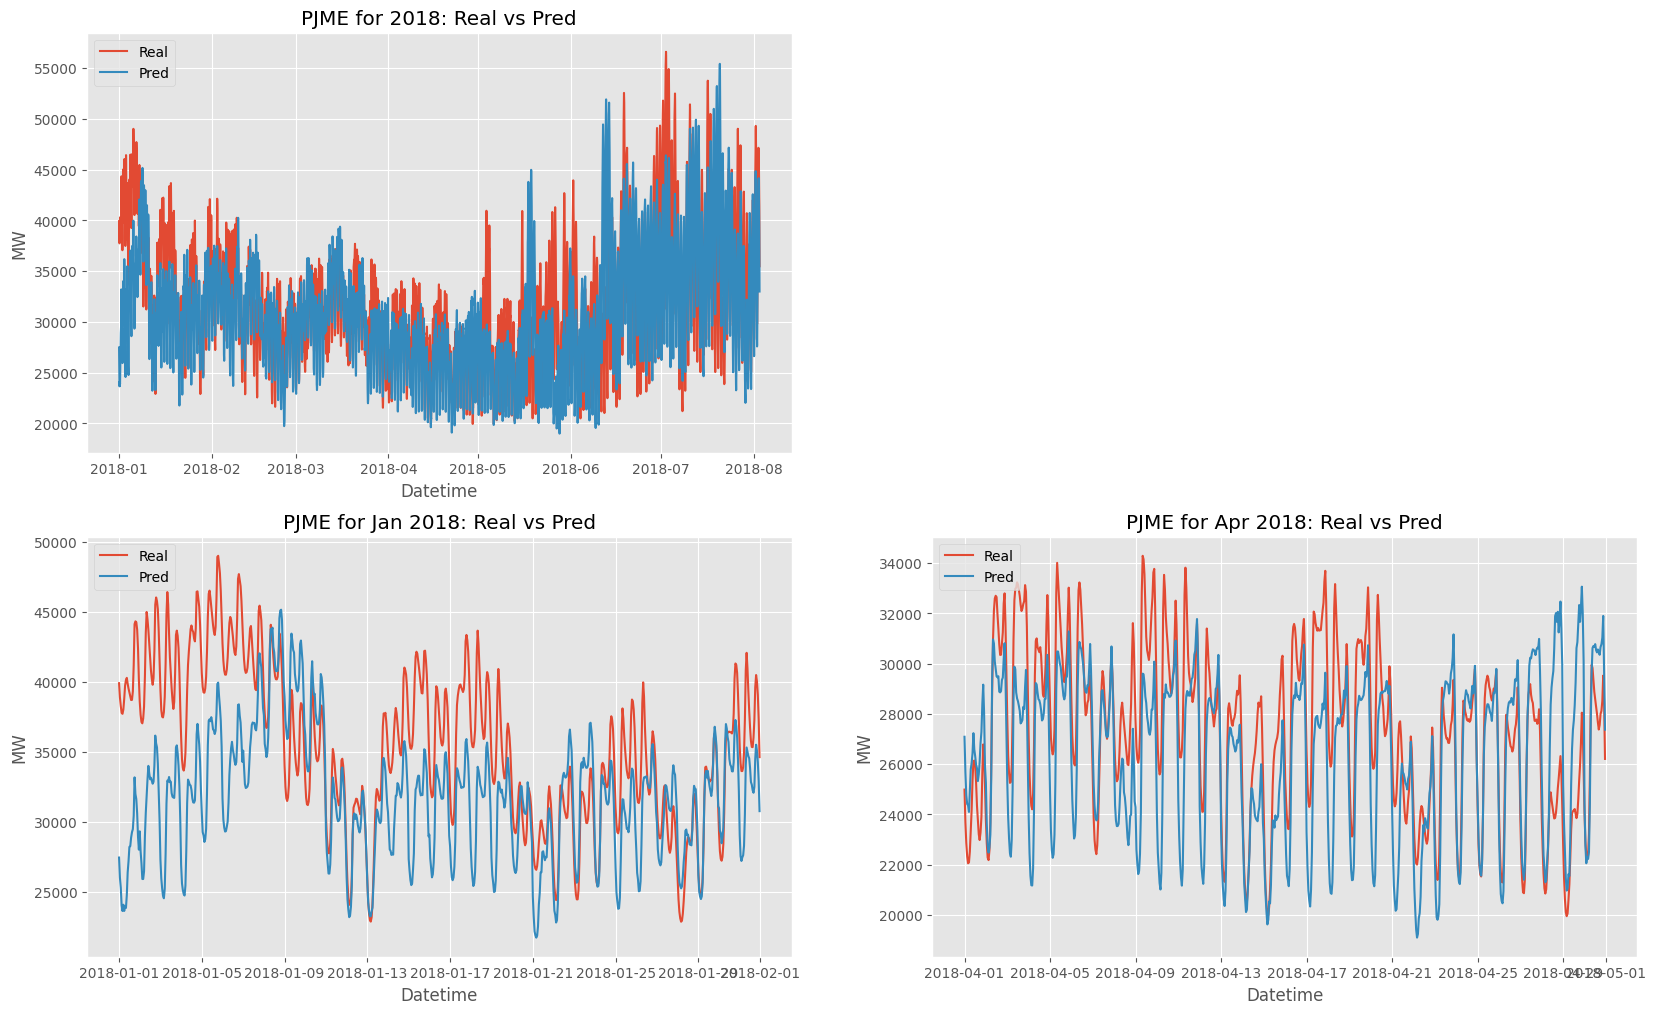

In [129]:
# Plots
plt.figure(figsize=(20,12))

plt.subplot(2,2,1)

sns.lineplot(data=df_p1_pred, x='Datetime', y='PJME_MW', label="Real")
sns.lineplot(data=df_p1_pred, x='Datetime', y='PJME_MW_Pred', label="Pred")

plt.title('PJME for 2018: Real vs Pred')
plt.xlabel('Datetime')
plt.ylabel('MW')
plt.legend(title='', loc='upper left', fontsize=10)
plt.grid(True)

plt.subplot(2,2,3)
df_p1_pred_Feb =df_p1_pred[df_p1_pred['Month'] == 1]

sns.lineplot(data=df_p1_pred_Feb, x='Datetime', y='PJME_MW', label="Real")
sns.lineplot(data=df_p1_pred_Feb, x='Datetime', y='PJME_MW_Pred', label="Pred")

plt.title('PJME for Jan 2018: Real vs Pred')
plt.xlabel('Datetime')
plt.ylabel('MW')
plt.legend(title='', loc='upper left', fontsize=10)
plt.grid(True)

plt.subplot(2,2,4)
df_p1_pred_Feb =df_p1_pred[df_p1_pred['Month'] == 4]

sns.lineplot(data=df_p1_pred_Feb, x='Datetime', y='PJME_MW', label="Real")
sns.lineplot(data=df_p1_pred_Feb, x='Datetime', y='PJME_MW_Pred', label="Pred")

plt.title('PJME for Apr 2018: Real vs Pred')
plt.xlabel('Datetime')
plt.ylabel('MW')
plt.legend(title='', loc='upper left', fontsize=10)
plt.grid(True)

## Problem 2 - Forecast with Time Series Features on Any Datetime

## FINAL Problem -
